In [11]:
%matplotlib inline

import time
import random
import threading
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from cclyde import Cluster
from distributed import Client, progress
from pprint import pprint


from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits

requests.packages.urllib3.connectionpool - INFO - Starting new HTTPS connection (1): api.plot.ly


# MNIST dataset
### Grayscale hand-written digits

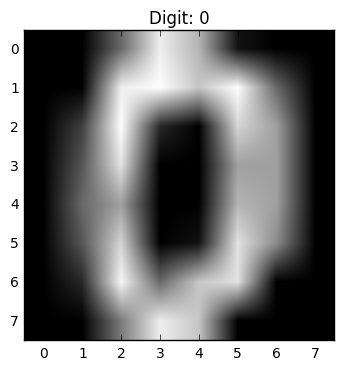

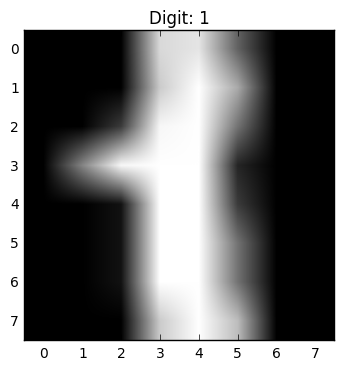

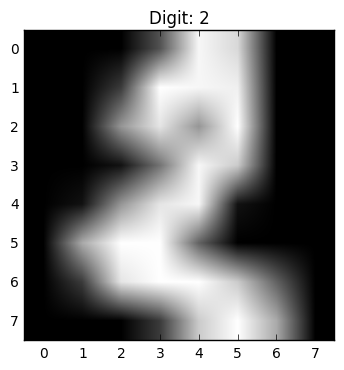

In [2]:
X, y = load_digits(return_X_y=True)
X = np.asarray([x.flatten() for x in X])

for i in range(3):
    plt.imshow(X[i].reshape((8, 8)), cmap='Greys_r')
    plt.title('Digit: {}'.format(y[i]))
    plt.show()

# Train a Linear classfier to predict digits
## This also demonstrates the time problem of adjusting hyper-parameters

---

- Trained with alpha of 0.001...

In [3]:
pca = PCA(n_components=10)

X = pca.fit_transform(X)

In [4]:

lr = Perceptron(penalty=None, n_iter=5)

start = time.time()
scores = cross_val_score(estimator=lr,
                         X=X, 
                         y=y,
                         cv=3)

print("Accuracy: {}% (+/- {})".format(round(scores.mean() * 100, 2), round(scores.std(), 3) * 2))
print('Finished in {}sec'.format(round(time.time() - start, 2)))

Accuracy: 73.97% (+/- 0.06)
Finished in 0.04sec


- Trained with alpha of 0.2...

In [5]:
lr = Perceptron(penalty=None, n_iter=15)

start = time.time()
scores = cross_val_score(estimator=lr,
                         X=X, 
                         y=y,
                         cv=3)

print("Accuracy: {}% (+/- {})".format(round(scores.mean() * 100, 2), round(scores.std(), 3) * 2))
print('Finished in {}sec'.format(round(time.time() - start, 2)))

Accuracy: 80.08% (+/- 0.044)
Finished in 0.07sec


## Issue: What hyper params are best? 

Train for all/most?

In [6]:

# Define hyper parameter ranges
penalties = ['l1',]
alphas = np.random.uniform(low=0.0001, high=0.5, size=50)
#n_iters = np.random.randint(low=1, high=200, size=75)
n_iters = [int(n) for n in np.linspace(1, 300, num=75)]

# Make a list of all combinations
params = []
for penalty in penalties:
    for alpha in alphas:
        for n_iter in n_iters:
            
            params.append({'penalty': penalty,
                           'alpha': round(alpha, 4),
                           'n_iter': n_iter
                          })

print '{} different combinations.'.format(len(params))
pprint(params[:2])

3750 different combinations.
[{'alpha': 0.2014, 'n_iter': 1, 'penalty': 'l1'},
 {'alpha': 0.2014, 'n_iter': 5, 'penalty': 'l1'}]


# This will take a while, even if using all cores on a local machine; let's distribute the workload

In [7]:
cluster = Cluster(n_nodes=10, instance_type='t2.medium', key_name='cclyde_windows')

Connecting to Boto3 and EC2 resources...Done. 
Ready to configure in preparation to launch cluster! Run: >>> cluster.configure()


In [8]:
cluster.configure()

Checking keypair exists using key_name: "cclyde_windows"...
	Found pem_key: "cclyde_windows"...Done.
Checking for Cluster Clyde's Virtual Private Cloud (cclyde_vpc) on AWS...
	Found existing VPC...Done.
Checking for Cluster Clyde's Subnet in the VPC...
	Found existing subnet...Done.
Validating security group...

requests.packages.urllib3.connectionpool - INFO - Starting new HTTP connection (1): whatismyip.org


Found existing cclyde security group, connecting to it...Done.
Configuring security group...
	Working on permission: tcp from port: 22 to port: 22...already exists! Passing.

	Working on permission: tcp from port: 80 to port: 8786...already exists! Passing.

	Working on permission: tcp from port: 80 to port: 8787...already exists! Passing.

	Working on permission: tcp from port: 0 to port: 65535...already exists! Passing.
Done configuring security group.
Checking for Cluster Clyde's internet gateway...found existing cclyde gateway...Done.
Attaching internet gateway to VPC if needed...gateway already associated with VPC...Done.
Confirming proper VPC route table configuration...Found existing route table, confirming proper config...Done.
Everything is configured, you can now run >>> cluster.launch_instances() OR cluster.reconnect_to_cluster()

In [9]:
cluster.reconnect_to_cluster()


Connected to exiting running instances. Count: 10, cluster_name: default


In [9]:
cluster.launch_instances()

Cluster-Clyde - WARNING - 	Once instances are running, you may be accumulating charges from AWS; be sure to run cluster.stop_cluster() *AND* confirm instances are stopped/terminated via AWS console!


All instances in running state, waiting for all to be reachable...
All 10 instances ready!
Setting node names...Done.
Installing Anaconda on cluster...



paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ

Done.

In [10]:
cluster.install_python_packages(['scikit-learn', 'numpy', 'pandas', 'dask', 'futures'], method='conda')


Installing package: keras

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: scikit-learn

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: numpy

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: pandas

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: dask

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: futures

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

----------
cclyde_node-8 	Exit code: 0

----------
cclyde_node-9 	Exit code: 0

Installing package: git+git://github.com/dask/distributed.git

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


----------
cclyde_node-master 	Exit code: 1

----------
cclyde_node-1 	Exit code: 1

----------
cclyde_node-2 	Exit code: 1

----------
cclyde_node-3 	Exit code: 1

----------
cclyde_node-4 	Exit code: 1

----------
cclyde_node-5 	Exit code: 1

----------
cclyde_node-6 	Exit code: 1

----------
cclyde_node-7 	Exit code: 1

----------
cclyde_node-8 	Exit code: 1

----------
cclyde_node-9 	Exit code: 1


True

In [11]:
cluster.launch_dask()

Installing dask.distributed on cluster


paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) succ


Node: cclyde_node-master exit code: 0
Node: cclyde_node-1 exit code: 0
Node: cclyde_node-2 exit code: 0
Node: cclyde_node-3 exit code: 0
Node: cclyde_node-4 exit code: 0
Node: cclyde_node-5 exit code: 0
Node: cclyde_node-6 exit code: 0
Node: cclyde_node-7 exit code: 0
Node: cclyde_node-8 exit code: 0
Node: cclyde_node-9 exit code: 0
Launching scheduler on master node...

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!


Done.

Launching workers...

paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Connected (version 2.0, client OpenSSH_7.2p2)
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!
paramiko.transport - INFO - Authentication (publickey) successful!

Done.

Scheduler should be available here: 52.23.188.7:8786
Web Dashboard should be available here: 52.23.188.7:8787

# Define function which will initialize model with given params, train, test and send back the score.

In [40]:
def get_data(kwargs):
    """
    Function which gets data and performs PCA on it.
    """
    from sklearn.datasets import load_digits
    from sklearn.decomposition import PCA
    import numpy as np
    
    X, y = load_digits(return_X_y=True)
    X = np.asarray([x.flatten() for x in X])
    pca = PCA(n_components=40)
    X = pca.fit_transform(X)
    
    return (kwargs, X, y)


def model_tester(package):
    """
    Function which is mapped to cluster. Passes kwargs to model to be trained.
    Returns score based on those kwargs.
    """
    
    kwargs, X, y = package
    
    import time
    import numpy as np
    from sklearn.linear_model import Perceptron
    from sklearn.model_selection import cross_val_score
    
    # Initialize model with given kwargs
    lr = Perceptron(**kwargs)
    scores = cross_val_score(estimator=lr,
                             X=X, 
                             y=y,
                             cv=2)
    return (kwargs, scores.mean(), scores.std())


def score_combiner(package):
    """
    Not needed, but more functions == more pretty colors
    """
    import time
    import random
    time.sleep(random.random())
    
    kwargs, score_m, score_std = package
    kwargs.update({'score': score_m, 'std': score_std})
    
    return kwargs


def double(n):
    '''
    Useless worker function # 1
    '''
    import time
    import random
    import sklearn
    time.sleep(random.random())
    return n * 2, 2


def add_two(package):
    """
    Useless worker function # 2
    """
    n, n2 = package
    import time
    import random
    time.sleep(random.random())
    return n + n2
    

In [10]:
c = Client(address='52.23.188.7:8786')
c.restart()

<Client: scheduler="52.23.188.7:8786" processes=9 cores=18>

In [18]:
futures = c.map(double, range(200))
futures = c.map(add_two, futures)
progress(futures)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [41]:
futures = c.map(get_data, params)
futures = c.map(model_tester, futures)
futures = c.map(score_combiner, futures)
progress(futures)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [42]:
results = c.gather(futures)

In [43]:
df = pd.DataFrame(results)
df.head()

,alpha,n_iter,penalty,score,std
0,0.4884,1,l1,0.267678,0.003527
1,0.4884,5,l1,0.434692,0.028477
2,0.4884,9,l1,0.372788,0.020109
3,0.4884,13,l1,0.435117,0.018823
4,0.4884,17,l1,0.317722,0.010802


In [45]:
temp = df[df.penalty == 'l1']

trace1 = go.Scatter(
    x = temp.n_iter,
    y = temp.alpha,
    mode='markers',
    name=temp.penalty,
    marker=dict(
        size='16',
        color = temp.score, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]

layout = dict(title = 'Best performing models.',
              yaxis = dict(zeroline = False, title='Alpha'),
              xaxis = dict(zeroline = False, title='Iterations')
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')


requests.packages.urllib3.connectionpool - INFO - Starting new HTTPS connection (1): plot.ly


# Also create a distributed queue system...

In [12]:
from Queue import Queue
local_q = Queue()
remote_q = c.scatter(local_q)

def long_calc1(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n + 2

def long_calc2(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n * 2

def long_calc3(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n - 2


long_calc1_q = c.map(long_calc1, remote_q)
long_calc2_q = c.map(long_calc2, long_calc1_q)
long_calc3_q = c.map(long_calc3, long_calc2_q)
result_q = c.gather(long_calc3_q)



## queue is currently empty...

In [13]:
result_q.qsize()

0

## Start submitting jobs to the queue with a thread

In [14]:
def start_jobs():

    jobs = range(500)

    for job in jobs:
        time.sleep(random.random())
        local_q.put(job)
        
    return 

thread = threading.Thread(target=start_jobs)
thread.start()

## and begin receiving the results...

In [17]:
def get_jobs():
    while True:
        print result_q.get()
        
    return

finish_thread = threading.Thread(target=get_jobs)
finish_thread.start()

218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526
528
530
532
534
536
538
540
542
544
546
548
550
552
554
556
558
560
562
564
566
568
570
572
574
576
578
580
582
584
586
588
590
592
594
596
598
600
602
604
606
608
610
612
614
616
618
620
622
624
626
628
630
632
634
636
638
640
642
644
646
648
650
652
654
656
658
660
662
664
666
668
670
672
674
676
678
680
682
684
686
688
690
692
694
696
698
700
702
704
706
708
710
712
714
716


In [18]:
finish_thread.is_alive()

True